In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

**Gerekli Kütüphaneleri Yükleme**

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# Veri setinin olduğu klasör
dataset_path = "/kaggle/input/brain-tumor-classification-mri/Training"

# Kategoriler (sınıflar)
categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Veriyi ve etiketleri saklamak için listeler
X = []
y = []

# Her bir kategori için işlemleri yap
for category in categories:
    class_index = categories.index(category)  # Sınıf numarası (0,1,2,3)
    path = os.path.join(dataset_path, category)  # İlgili klasörün yolu
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            img = cv2.imread(img_path)  
            img = cv2.resize(img, (224, 224))  
            X.append(img)
            y.append(class_index)
        except Exception as e:
            print("Hata:", e)

# Listeyi NumPy dizisine çeviriyoruz
X = np.array(X) / 255.0  # Normalizasyon yapıyoruz
y = np.array(y)

# Veriyi eğitim ve test seti olarak bölelim (%80 train, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-Hot Encoding yapıyoruz (4 sınıf olduğu için)
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

print("Eğitim veri seti boyutu:", X_train.shape)
print("Test veri seti boyutu:", X_test.shape)


Eğitim veri seti boyutu: (2296, 224, 224, 3)
Test veri seti boyutu: (574, 224, 224, 3)


In [4]:
datagen = ImageDataGenerator(
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode="nearest"
)
datagen.fit(X_train)


In [5]:
from tensorflow.keras import layers, models, Input

model = models.Sequential()

model.add(Input(shape=(224,224,3)))

# 1. Konvolüsyon Katmanı
model.add(layers.Conv2D(16, (3,3), activation="relu"))
model.add(layers.MaxPooling2D(2,2))

# 2. Konvolüsyon Katmanı
model.add(layers.Conv2D(32, (3,3), activation="relu"))
model.add(layers.MaxPooling2D(2,2))

# 3. Konvolüsyon Katmanı
model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D(2,2))

# 4. Konvolüsyon Katmanı
model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPooling2D(2,2))

# Düzleştirme (Flatten)
model.add(layers.Flatten())

# Tam Bağlantılı Katmanlar
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.4))  # Overfitting'i önlemek için
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(4, activation="softmax"))  # 4 sınıf olduğu için softmax kullanıyoruz

# Modeli Özetle
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,465,380 (9.40 MB)

 Trainable params: 2,465,380 (9.40 MB)

 Non-trainable params: 0 (0.00 B)

**Modeli Derleme (Compile)**

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


**TensorFlow Veri Seti Dönüştürme**

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

**Modeli Eğitme**

In [8]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.4562 - loss: 1.2086 - val_accuracy: 0.6429 - val_loss: 0.8667
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6677 - loss: 0.7935 - val_accuracy: 0.7247 - val_loss: 0.6639
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7419 - loss: 0.6258 - val_accuracy: 0.7997 - val_loss: 0.5113
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7891 - loss: 0.5040 - val_accuracy: 0.8049 - val_loss: 0.4492
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8340 - loss: 0.4140 - val_accuracy: 0.8467 - val_loss: 0.3818
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8847 - loss: 0.3184 - val_accuracy: 0.8763 - val_loss: 0.3080
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8933 - loss: 0.2600 - val_accuracy: 0.8571 - val_loss: 0.3547
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9110 - loss: 0.2102 - val_accuracy: 0.8763 -

**Modeli Test Etme**

In [9]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9067 - loss: 0.5417
Test Loss: 0.4447
Test Accuracy: 0.9129


**Confusion Matrix ve Classification Report**

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


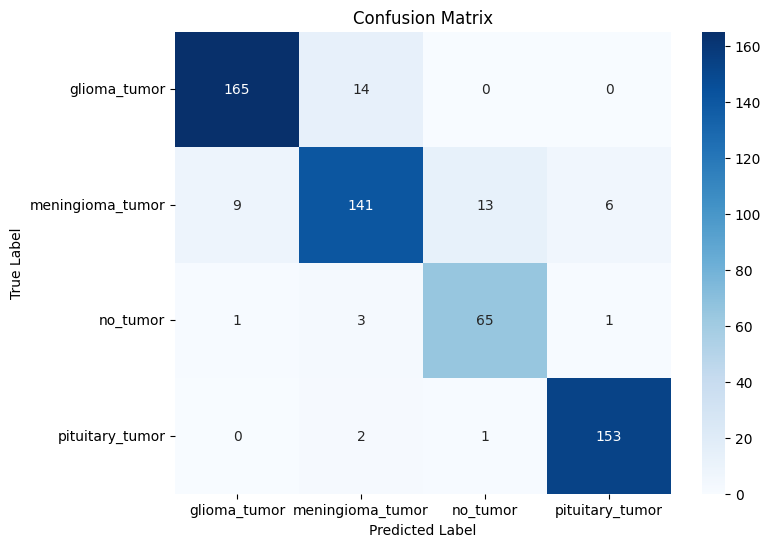

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.92      0.93       179
meningioma_tumor       0.88      0.83      0.86       169
        no_tumor       0.82      0.93      0.87        70
 pituitary_tumor       0.96      0.98      0.97       156

        accuracy                           0.91       574
       macro avg       0.90      0.92      0.91       574
    weighted avg       0.91      0.91      0.91       574



In [10]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=categories))